In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [39]:
%matplotlib inline

import os
import h5py
import json
import itertools
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.stats import zscore
from scipy import stats as scipystats
from scipy.spatial.distance import cosine
from sklearn import decomposition

from utils.neurosuite import get_unit_names_sorted
from utils.behavior import get_idxs_as_periods
from utils.states import get_state_as_periods
#from utils.events import get_sound_event_periods

In [114]:
#source  = '/Users/andrey/sandbox/'
source  = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
#source  = '/mnt/nevermind.data-share/ag-grothe/AG_Pecka/data/processed/'

#session = '013608_ppcSIT_2025-01-06_13-20-52'  # PPC
session = '013608_ppcSIT_2025-01-14_10-20-14'  # HPC
#session = '013608_ppcSIT_2025-01-15_14-56-18'  # HPC
#session = '013608_ppcSIT_2025-01-16_09-49-21'  # PPC
#session = '013608_ppcSIT_2025-01-20_09-38-20'  # HPC
#session = '013608_ppcSIT_2025-01-21_08-50-02'  # Thalamus
#session = '013608_ppcSIT_2025-01-22_12-59-00'  # PPC
#session = '013608_ppcSIT_2025-01-23_08-46-51'  # HPC

animal      = session.split('_')[0]
s_path = os.path.join(source, animal, session)
meta_file   = os.path.join(source, animal, session, 'meta.h5')
units_file  = os.path.join(source, animal, session, 'units.h5')
phsl_file = os.path.join(source, animal, session, 'analysis', 'sound_phase_lock.h5')

In [115]:
# reading events and spiking data
with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    sound_events = np.array(f['processed']['sound_events'])
    cfg = json.loads(f['processed'].attrs['parameters'])
    tgt_mx = np.array(f['processed']['target_matrix'])

spike_times = {}
with h5py.File(units_file, 'r') as f:
    unit_names = get_unit_names_sorted([name for name in f])
    for unit_name in f:
        spike_times[unit_name] = np.array(f[unit_name]['spike_times'])
        
spike_times_all = spike_times.copy()

In [116]:
x_pos_ev = tl[sound_events[:, 2].astype(np.int32)][:, 1]
y_pos_ev = tl[sound_events[:, 2].astype(np.int32)][:, 2]
speed_ev = tl[sound_events[:, 2].astype(np.int32)][:, 3]

speed_max = 0.04
idxs_sta_ev = np.where(speed_ev < speed_max)[0]
idxs_run_ev = np.where(speed_ev > speed_max)[0]
idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]
idxs_di1_ev = np.where(sound_events[:, 1] == 3)[0]
idxs_di2_ev = np.where(sound_events[:, 1] == 4)[0]

# success stays
idxs_tgt_succ = []
tgt_mx_succ = tgt_mx[tgt_mx[:, 4] == 1]
for tgt_rec in tgt_mx_succ:
    idxs_tgt_succ += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
idxs_tgt_succ = np.array(idxs_tgt_succ)

tgt_succ_pos_mx = np.zeros([len(tgt_mx_succ), 4])
for i, tgt_rec in enumerate(tgt_mx_succ):
    x_pos = tl[np.arange(tgt_rec[2], tgt_rec[3])][:, 1]
    y_pos = tl[np.arange(tgt_rec[2], tgt_rec[3])][:, 2]
    
    tgt_succ_pos_mx[i] = [tgt_rec[0], tgt_rec[1], x_pos.mean(), y_pos.mean()]

In [117]:
bgr_sta_long_mx, idxs_bgr_sta_long = get_state_as_periods(s_path, 'BGR', 'STA', None, 11, strip_l=0)
sil_sta_long_mx, idxs_sil_sta_long = get_state_as_periods(s_path, 'SIL', 'STA', None, 11, strip_l=0)
bgr_sta_AL_mx, idxs_bgr_sta_AL = get_state_as_periods(s_path, 'BGR', 'STA', 'AL', 12)
len(idxs_bgr_sta_long), len(idxs_sil_sta_long), len(idxs_bgr_sta_AL)

(498, 469, 421)

In [118]:
# MRL
MRL_mx = np.zeros([len(unit_names), 2])  # MRL, p-value
with h5py.File(phsl_file, 'r') as snd_f:
    for i, unit_name in enumerate(unit_names):
        MRL = np.array(snd_f['tgt'][unit_name]['MRL_real'])
        pv  = np.array(snd_f['tgt'][unit_name]['p_value'])
        MRL_mx[i] = np.array([MRL, pv])

In [119]:
# mean firing rate
FR_mx = np.zeros([len(unit_names), 2])  # MRL, mean rate, median ISI
for i, unit_id in enumerate(unit_names):
    spiketrain = spike_times[unit_id]
   
    mean_rate = len(spiketrain) / (tl[-1][0] - tl[0][0])
    
    isis = np.diff(spiketrain)
    robust_rate = 1 / np.median(isis)
    
    FR_mx[i] = np.array([mean_rate, robust_rate])

## Unit filtering

In [120]:
# special units 
special = {
    '013608_ppcSIT_2025-01-14_10-20-14': ['2-142', '2-234', '3-217', '4-198'],
    '013608_ppcSIT_2025-01-15_14-56-18': ['2-166', '2-288', '3-258', '4-231'],
    '013608_ppcSIT_2025-01-20_09-38-20': ['2-160', '2-241', '3-221', '4-201']
}

# exclude some?
#for unit in special['013608_ppcSIT_2025-01-14_10-20-14']:
#    spike_times.pop(unit)

idxs_special = [unit_names.index(x) for x in special[session]]
print(f"{len(idxs_special)} units to be excluded as special")

# MRL criteria
pv_min = 0.3
MRL_min = 0.05
MFR_min = 0.5

idxs_mfr_min = np.where(FR_mx[:, 0] > MFR_min)[0]
print(f"{len(idxs_mfr_min)} out of {len(unit_names)} units > 0.5Hz firing rate")
    
# MRL
idxs_MRL_high = np.where((MRL_mx[:, 0] > MRL_min) & (MRL_mx[:, 1] < pv_min))[0]
idxs_MRL_low  = np.where(MRL_mx[:, 0] < MRL_min)[0]

idxs_MRL_high = np.intersect1d(idxs_mfr_min, idxs_MRL_high)
idxs_MRL_high = np.setdiff1d(idxs_MRL_high, idxs_special)
idxs_MRL_low = np.intersect1d(idxs_mfr_min, idxs_MRL_low)
idxs_MRL_low = np.setdiff1d(idxs_MRL_low, idxs_special)

idxs_mfr_spc = np.setdiff1d(idxs_mfr_min, idxs_special)

idxs_final_filt = idxs_mfr_spc
spike_times = {}
unit_ids = [unit_names[x] for x in idxs_final_filt]
for unit_id in unit_ids:
    spike_times[unit_id] = spike_times_all[unit_id]

print(f"{len(idxs_MRL_high)} units with phase locking")
print(f"{len(idxs_MRL_low)} units have kind of no phase locking")
print(f"{len(idxs_final_filt)} units selected")

4 units to be excluded as special
156 out of 213 units > 0.5Hz firing rate
46 units with phase locking
80 units have kind of no phase locking
152 units selected


## Unit activity matrix

In [121]:
# unit activity matrix
unit_mx_database = {}

In [122]:
# OPTION 1 - sound events binning
t_bins = sound_events[:, 0]
unit_mx = np.zeros([len(spike_times), len(t_bins)-1])
for i, (unit_name, s_times) in enumerate(spike_times.items()):
    unit_mx[i], _ = np.histogram(s_times, bins=t_bins)

unit_mx = zscore(unit_mx, axis=1)
unit_mx_database[1] = unit_mx.T.copy()

unit_mx.shape

(152, 9599)

In [123]:
# OPTION 2 - few sound events unwrapped in the future
unwrap_count = 1  # plus one more event

t_bins = sound_events[:, 0]
unit_mx = np.zeros([len(spike_times), len(t_bins)-1])  # units, sound events
for i, (unit_name, s_times) in enumerate(spike_times.items()):
    unit_mx[i], _ = np.histogram(s_times, bins=t_bins)
unit_mx = zscore(unit_mx, axis=1)  # sound events, units

res = unit_mx.copy()
for i in range(unwrap_count):
    res = np.vstack([res, np.roll(unit_mx, -i-1)])  # should be - ?

unit_mx_database[2] = res.T.copy()

unit_mx.shape, res.shape

((152, 9599), (304, 9599))

In [124]:
# OPTION 3 - mean of two sound events
t_bins = sound_events[:, 0]
unit_mx = np.zeros([len(spike_times), len(t_bins)-1])
for i, (unit_name, s_times) in enumerate(spike_times.items()):
    unit_mx[i], _ = np.histogram(s_times, bins=t_bins)

ev_count = unit_mx.shape[1]
if ev_count % 2 > 0:
    unit_mx = unit_mx[:, :ev_count-1]

mx_even = unit_mx.T[::2]
mx_odd  = unit_mx.T[1::2]

unit_mx = ((mx_even + mx_odd)/2).T
unit_mx = zscore(unit_mx, axis=1)
unit_mx_database[3] = unit_mx.T.copy()

# reshape to event size!!

unit_mx.shape

(152, 4799)

In [125]:
# OPTION 4 - 50ms binning
bin_size = 0.05
bins_to_add = int(0.25/bin_size) - 1

t_bins = sound_events[:, 0]
res = t_bins.copy()
for i in range(bins_to_add):
    res = np.vstack([res, t_bins + (i+1) * bin_size])

t_bins = res.T.flatten()

unit_mx = np.zeros([len(spike_times), len(t_bins)-1])
for i, (unit_name, s_times) in enumerate(spike_times.items()):
    unit_mx[i], _ = np.histogram(s_times, bins=t_bins)
unit_mx = zscore(unit_mx, axis=1)

# reshape to event size!!
unwrap_count = 4
res = unit_mx.copy()
for i in range(unwrap_count):
    res = np.vstack([res, np.roll(unit_mx, -i-1)])  # should be - ?

unit_mx_database[4] = res.T[::5].copy()

unit_mx_database[4].T.shape

(760, 9600)

## PCA between states

In [126]:
# select which unit activity matrix
unit_mx = unit_mx_database[1]

In [127]:
event_matrices = {
    'tgt_succ_pos_mx': idxs_tgt_succ,
    'bgr_sta_long_mx': idxs_bgr_sta_long,
    'sil_sta_long_mx': idxs_sil_sta_long,
}
colors = {
    'tgt_succ_pos_mx': 'tab:orange',
    'bgr_sta_long_mx': 'tab:blue',
    'sil_sta_long_mx': 'grey',
}

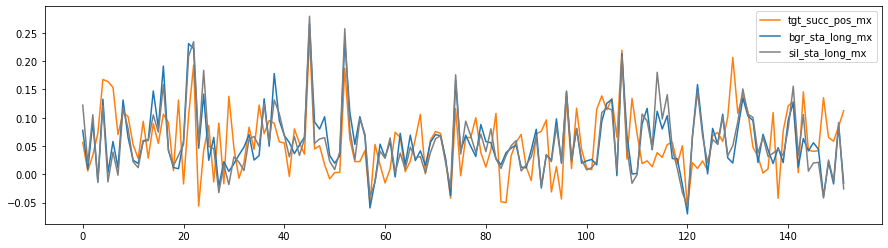

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

eignvectors = []
for mx_name, idxs_state in event_matrices.items():
    unit_mx_state = unit_mx[idxs_state]
    ev_pca = decomposition.PCA(n_components=3)
    ev_X   = ev_pca.fit_transform(unit_mx_state)
    eignvectors.append(ev_pca.components_[0])
    
    ax.plot(ev_pca.components_[0], color=colors[mx_name], label=mx_name)
    ax.legend()

In [129]:
combs = {
    'TGT-BGR': (0, 1),
    'TGT-SIL': (0, 2),
    'BGR-SIL': (1, 2)
}

for name, comb in combs.items():
    v1 = eignvectors[comb[0]]
    v2 = eignvectors[comb[1]]
    
    # Cosine similarity (1 - cosine distance)
    cos_sim = 1 - cosine(v1, v2)
   
    # standard pearsons corr coeff
    corr, pv = scipystats.pearsonr(v1, v2)
    
    print(f'{name}: corr: {corr:.3f}, p-value: {pv:.5f}, cosine: {cos_sim:.3f}')

TGT-BGR: corr: 0.428, p-value: 0.00000, cosine: 0.722
TGT-SIL: corr: 0.454, p-value: 0.00000, cosine: 0.728
BGR-SIL: corr: 0.947, p-value: 0.00000, cosine: 0.974


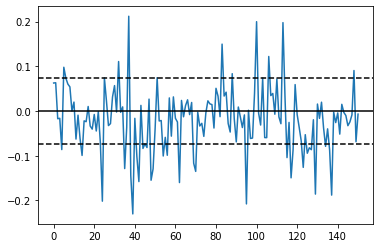

In [91]:
pc1_tgt = eignvectors[0]
pc1_bgr = eignvectors[1]
pc1_sil = eignvectors[2]

pc1_tgt_diff = pc1_tgt - (pc1_bgr + pc1_sil)/2
top_indices = np.argsort(np.abs(pc1_tgt_diff))

plt.plot(pc1_tgt_diff)
plt.axhline(0, color='black')
plt.axhline( pc1_tgt_diff.std(), color='black', ls='--')
plt.axhline(-pc1_tgt_diff.std(), color='black', ls='--')

In [92]:
# top 50 different
print([unit_ids[x] for x in top_indices[-50:]])

['1-285', '1-111', '4-316', '4-67', '3-403', '1-518', '4-232', '2-447', '3-501', '1-157', '1-555', '2-498', '4-372', '2-460', '4-335', '3-387', '2-445', '4-281', '1-121', '4-337', '4-374', '4-64', '4-326', '1-143', '2-535', '1-459', '2-500', '2-421', '4-251', '2-175', '3-289', '3-63', '4-317', '2-346', '2-485', '3-291', '2-381', '3-364', '4-261', '2-480', '2-424', '2-92', '4-353', '4-388', '4-248', '3-452', '1-524', '3-430', '2-378', '2-398']


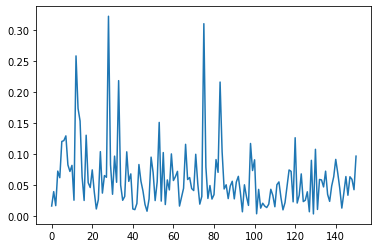

In [103]:
plt.plot(MRL_mx[idxs_final_filt][top_indices][:, 0])